# A./ Preprocessing

> ### Data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Load data
data = pd.read_csv('../data/raw/sp500.csv', index_col='Date', parse_dates=True)

# Convert columns to numeric
data = data.apply(pd.to_numeric, errors='coerce')

# Focus only on the 'Close' price
close_prices = data['Close']

> ### Compute Log Returns

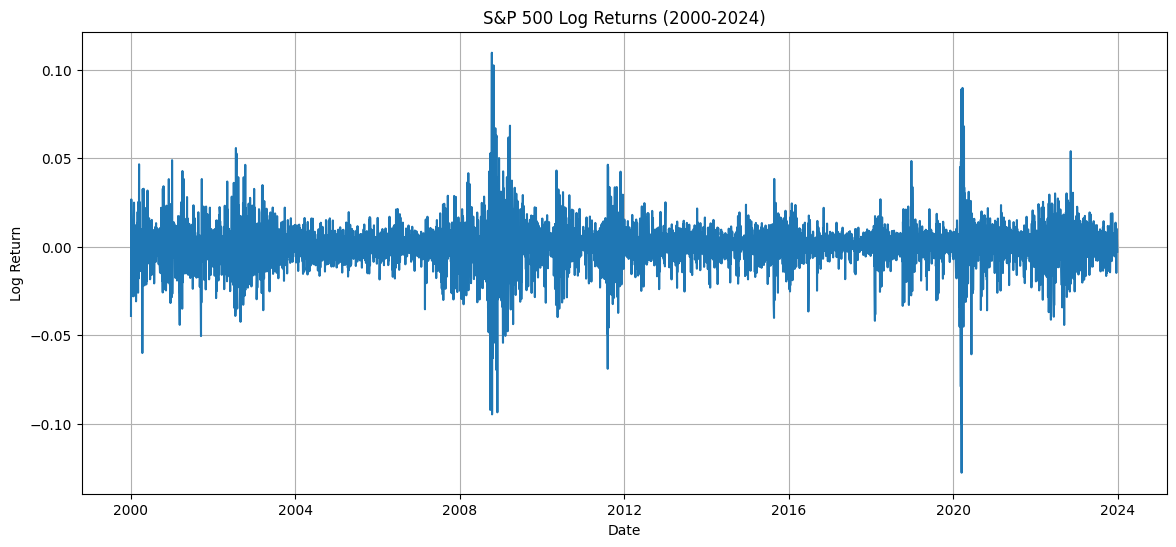

In [2]:
# Compute log returns
log_returns = np.log(close_prices / close_prices.shift(1)).dropna()

# Plot log returns
plt.figure(figsize=(14,6))
plt.plot(log_returns)
plt.title('S&P 500 Log Returns (2000-2024)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.show()

>### Test for Stationarity using ADF Test

In [3]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(log_returns)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

# Interpretation
if adf_result[1] <= 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

ADF Statistic: -18.6414522228801
p-value: 2.053930832587565e-30
The series is likely stationary (reject H0).


# B./ Fit a Baseline ARIMA Model

In [5]:
# Import ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Define and fit the ARIMA model
# We start simple with an ARIMA(1,0,1) model: (p=1, d=0, q=1)
model = ARIMA(log_returns, order=(1, 0, 1))
arima_result = model.fit()

# Print model summary
print(arima_result.summary())

C:\Users\HP\Desktop\AIMS\Block 2025\DDO\control-hand-project\myvenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\Desktop\AIMS\Block 2025\DDO\control-hand-project\myvenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\Desktop\AIMS\Block 2025\DDO\control-hand-project\myvenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 6036
Model:                 ARIMA(1, 0, 1)   Log Likelihood               17976.681
Date:                Sat, 26 Apr 2025   AIC                         -35945.361
Time:                        09:52:50   BIC                         -35918.539
Sample:                             0   HQIC                        -35936.049
                               - 6036                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.289      0.197      -0.000       0.000
ar.L1          0.0545      0.050      1.093      0.274      -0.043       0.152
ma.L1         -0.1584      0.050     -3.163      0.0

In [10]:
import joblib

# Save ARIMA model
joblib.dump(arima_result, '../models/arima_model.pkl')
print("ARIMA model saved.")

ARIMA model saved.


>### Forecast with the ARIMA Model and Plot the Results

C:\Users\HP\Desktop\AIMS\Block 2025\DDO\control-hand-project\myvenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HP\Desktop\AIMS\Block 2025\DDO\control-hand-project\myvenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


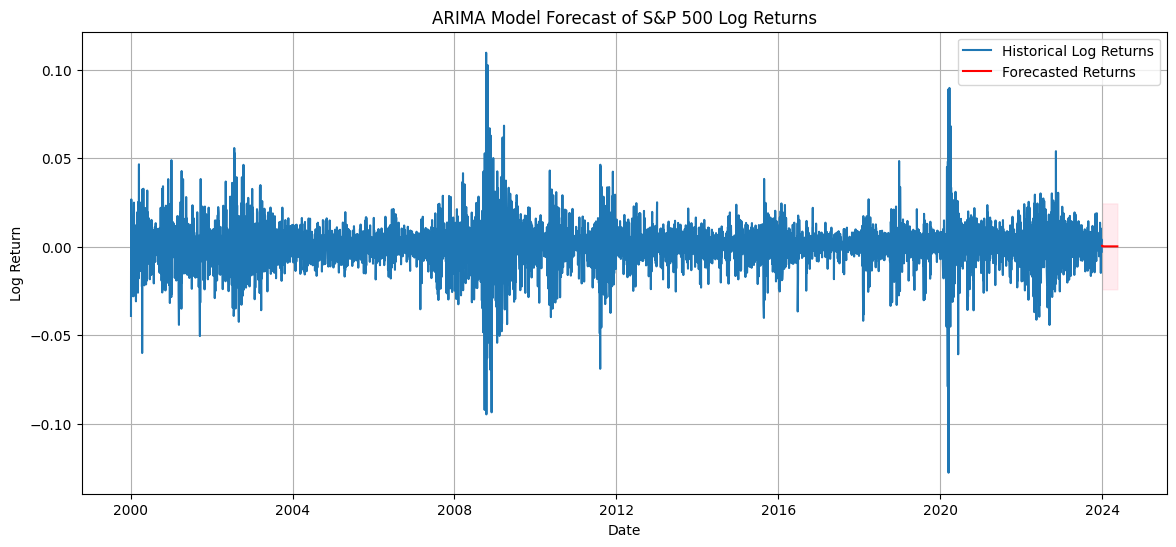

In [6]:
# Forecast future values
n_forecast = 100  # Number of steps ahead to forecast
forecast = arima_result.get_forecast(steps=n_forecast)

# Get forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Create forecast index
forecast_index = pd.date_range(start=log_returns.index[-1] + pd.Timedelta(days=1), periods=n_forecast, freq='B')

# Plot the results
plt.figure(figsize=(14,6))
plt.plot(log_returns, label='Historical Log Returns')
plt.plot(forecast_index, forecast_mean, color='red', label='Forecasted Returns')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Model Forecast of S&P 500 Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.show()

# C./ Fit a GARCH Model to Capture Volatility

In [8]:
!pip install arch

   ---------------------------------------- 0.0/926.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/926.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/926.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/926.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/926.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/926.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/926.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/926.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/926.2 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.2 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.2 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.2 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.2 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.2 kB ? eta -:--


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
# Import GARCH model
from arch import arch_model

# Define and fit GARCH(1,1) model
garch_model = arch_model(log_returns, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')

# Print model summary
print(garch_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                19414.6
Distribution:                  Normal   AIC:                          -38821.1
Method:            Maximum Likelihood   BIC:                          -38794.3
                                        No. Observations:                 6036
Date:                Sat, Apr 26 2025   Df Residuals:                     6035
Time:                        09:56:00   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         5.7397e-04  2.528e-06    227.075      0.000 [5.

C:\Users\HP\Desktop\AIMS\Block 2025\DDO\control-hand-project\myvenv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001532. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [11]:
# Save GARCH model
joblib.dump(garch_result, '../models/garch_model.pkl')
print("GARCH model saved.")

GARCH model saved.
